In [2]:
"""
Reader Script for LiH QML Comparison Results

Loads data saved by run_comparison.py and generates plots/analysis.

Usage:
    python read_results.py <results_dir>
    python read_results.py results --plot all --save figures/
    
    or as module:
    from read_results import ResultsReader
    reader = ResultsReader("results")
    reader.plot_comparison()
"""

import numpy as np
import json
import os
import matplotlib.pyplot as plt
import argparse


class ResultsReader:
    """Reader for LiH QML comparison results."""
    
    def __init__(self, results_dir):
        """Load results from directory."""
        self.results_dir = results_dir
        self.results = None
        self.metrics = None
        
        self._load_data()
    
    def _load_data(self):
        """Load all data files."""
        print(f"Loading results from: {self.results_dir}")
        
        # Load JSON results
        json_path = os.path.join(self.results_dir, "results.json")
        if os.path.exists(json_path):
            with open(json_path, 'r') as f:
                self.results = json.load(f)
            print(f"  ✓ Loaded results.json")
        
        # Load numpy metrics
        npz_path = os.path.join(self.results_dir, "metrics.npz")
        if os.path.exists(npz_path):
            self.metrics = dict(np.load(npz_path))
            print(f"  ✓ Loaded metrics.npz")
    
    def print_summary(self):
        """Print summary statistics."""
        if not self.results:
            print("No results loaded")
            return
        
        config = self.results.get("config", {})
        
        print("\n" + "="*80)
        print("EXPERIMENT SUMMARY")
        print("="*80)
        print(f"Runs: {config.get('n_runs', 'N/A')}")
        print(f"Epochs: {config.get('n_epochs', 'N/A')}")
        print(f"Timestamp: {config.get('timestamp', 'N/A')}")
        
        print("\n" + "-"*80)
        print(f"{'Metric':<20} {'Equivariant':<30} {'Non-Equivariant':<30}")
        print("-"*80)
        
        metrics_to_show = ["E_r2", "E_mae_Ha", "E_rmse_Ha", "F_r2", "F_mae", "F_rmse"]
        
        for metric in metrics_to_show:
            eq_summary = self.results["equivariant"]["metrics_summary"].get(metric, {})
            neq_summary = self.results["non_equivariant"]["metrics_summary"].get(metric, {})
            
            eq_str = f"{eq_summary.get('mean', 0):.4f} ± {eq_summary.get('std', 0):.4f}"
            neq_str = f"{neq_summary.get('mean', 0):.4f} ± {neq_summary.get('std', 0):.4f}"
            
            print(f"{metric:<20} {eq_str:<30} {neq_str:<30}")
        
        print("="*80)
    
    def plot_comparison_bars(self, save_path=None, show=True):
        """Create bar chart comparing methods."""
        if not self.results:
            print("No results loaded")
            return None
        
        metrics = ["E_r2", "F_r2"]
        labels = ["Energy R²", "Force R²"]
        
        eq_means = []
        eq_stds = []
        neq_means = []
        neq_stds = []
        
        for m in metrics:
            eq_means.append(self.results["equivariant"]["metrics_summary"][m]["mean"])
            eq_stds.append(self.results["equivariant"]["metrics_summary"][m]["std"])
            neq_means.append(self.results["non_equivariant"]["metrics_summary"][m]["mean"])
            neq_stds.append(self.results["non_equivariant"]["metrics_summary"][m]["std"])
        
        x = np.arange(len(metrics))
        width = 0.35
        
        fig, ax = plt.subplots(figsize=(10, 6))
        
        bars1 = ax.bar(x - width/2, eq_means, width, yerr=eq_stds, 
                       label='Equivariant', color='#2ecc71', capsize=5, alpha=0.8)
        bars2 = ax.bar(x + width/2, neq_means, width, yerr=neq_stds,
                       label='Non-Equivariant', color='#e74c3c', capsize=5, alpha=0.8)
        
        ax.set_ylabel('R² Score', fontsize=12)
        ax.set_title('LiH Energy/Force Prediction: Equivariant vs Non-Equivariant QML', fontsize=14)
        ax.set_xticks(x)
        ax.set_xticklabels(labels, fontsize=12)
        ax.legend(fontsize=11)
        ax.set_ylim([0, 1.1])
        ax.axhline(y=1.0, color='gray', linestyle='--', alpha=0.5)
        ax.grid(True, alpha=0.3, axis='y')
        
        # Add value labels
        for bar, val in zip(bars1, eq_means):
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                   f'{val:.3f}', ha='center', va='bottom', fontsize=10)
        for bar, val in zip(bars2, neq_means):
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                   f'{val:.3f}', ha='center', va='bottom', fontsize=10)
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"Saved: {save_path}")
        
        if show:
            plt.show()
        else:
            plt.close()
        
        return fig
    
    def plot_mae_comparison(self, save_path=None, show=True):
        """Create bar chart for MAE comparison."""
        if not self.results:
            return None
        
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))
        
        # Energy MAE
        ax = axes[0]
        eq_mae = self.results["equivariant"]["metrics_summary"]["E_mae_Ha"]
        neq_mae = self.results["non_equivariant"]["metrics_summary"]["E_mae_Ha"]
        
        x = [0, 1]
        bars = ax.bar(x, [eq_mae["mean"], neq_mae["mean"]], 
                     yerr=[eq_mae["std"], neq_mae["std"]],
                     color=['#2ecc71', '#e74c3c'], capsize=5, alpha=0.8)
        ax.set_xticks(x)
        ax.set_xticklabels(['Equivariant', 'Non-Equivariant'])
        ax.set_ylabel('MAE (Hartree)', fontsize=12)
        ax.set_title('Energy MAE', fontsize=14)
        ax.grid(True, alpha=0.3, axis='y')
        
        # Force MAE
        ax = axes[1]
        eq_mae = self.results["equivariant"]["metrics_summary"]["F_mae"]
        neq_mae = self.results["non_equivariant"]["metrics_summary"]["F_mae"]
        
        bars = ax.bar(x, [eq_mae["mean"], neq_mae["mean"]], 
                     yerr=[eq_mae["std"], neq_mae["std"]],
                     color=['#2ecc71', '#e74c3c'], capsize=5, alpha=0.8)
        ax.set_xticks(x)
        ax.set_xticklabels(['Equivariant', 'Non-Equivariant'])
        ax.set_ylabel('MAE (eV/Å)', fontsize=12)
        ax.set_title('Force MAE', fontsize=14)
        ax.grid(True, alpha=0.3, axis='y')
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"Saved: {save_path}")
        
        if show:
            plt.show()
        else:
            plt.close()
        
        return fig
    
    def plot_training_curves(self, save_path=None, show=True):
        """Plot training loss curves."""
        if not self.results:
            return None
        
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))
        
        colors = {'equivariant': '#2ecc71', 'non_equivariant': '#e74c3c'}
        labels = {'equivariant': 'Equivariant', 'non_equivariant': 'Non-Equivariant'}
        
        for model_type in ['equivariant', 'non_equivariant']:
            runs = self.results[model_type]["runs"]
            
            # Collect all training curves
            all_E_loss = []
            all_F_loss = []
            epochs = None
            
            for run in runs:
                history = run.get("history", {})
                if history.get("epoch"):
                    epochs = history["epoch"]
                    all_E_loss.append(history.get("test_E_loss", []))
                    all_F_loss.append(history.get("test_F_loss", []))
            
            if not epochs or not all_E_loss:
                continue
            
            # Average across runs
            min_len = min(len(h) for h in all_E_loss)
            all_E_loss = [h[:min_len] for h in all_E_loss]
            all_F_loss = [h[:min_len] for h in all_F_loss]
            epochs = epochs[:min_len]
            
            mean_E = np.mean(all_E_loss, axis=0)
            std_E = np.std(all_E_loss, axis=0)
            mean_F = np.mean(all_F_loss, axis=0)
            std_F = np.std(all_F_loss, axis=0)
            
            # Energy loss
            axes[0].plot(epochs, mean_E, color=colors[model_type], 
                        label=labels[model_type], linewidth=2)
            axes[0].fill_between(epochs, mean_E - std_E, mean_E + std_E,
                                color=colors[model_type], alpha=0.2)
            
            # Force loss
            axes[1].plot(epochs, mean_F, color=colors[model_type],
                        label=labels[model_type], linewidth=2)
            axes[1].fill_between(epochs, mean_F - std_F, mean_F + std_F,
                                color=colors[model_type], alpha=0.2)
        
        axes[0].set_xlabel('Epoch', fontsize=12)
        axes[0].set_ylabel('Test Energy Loss (MSE)', fontsize=12)
        axes[0].set_title('Energy Training Progress', fontsize=14)
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)
        axes[0].set_yscale('log')
        
        axes[1].set_xlabel('Epoch', fontsize=12)
        axes[1].set_ylabel('Test Force Loss (MSE)', fontsize=12)
        axes[1].set_title('Force Training Progress', fontsize=14)
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)
        axes[1].set_yscale('log')
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"Saved: {save_path}")
        
        if show:
            plt.show()
        else:
            plt.close()
        
        return fig
    
    def plot_predictions(self, run_idx=0, save_path=None, show=True):
        """Plot predicted vs true values."""
        if not self.results:
            return None
        
        fig, axes = plt.subplots(2, 2, figsize=(12, 10))
        
        for col, model_type in enumerate(['equivariant', 'non_equivariant']):
            run = self.results[model_type]["runs"][run_idx]
            preds = run.get("predictions", {})
            
            if not preds:
                continue
            
            E_pred = np.array(preds["E_pred"])
            E_true = np.array(preds["E_true"])
            F_pred = np.array(preds["F_pred"])
            F_true = np.array(preds["F_true"])
            test_idx = preds["indices_test"]
            
            E_pred_test = E_pred[test_idx]
            E_true_test = E_true[test_idx]
            F_pred_test = F_pred[test_idx]
            F_true_test = F_true[test_idx]
            
            color = '#2ecc71' if model_type == 'equivariant' else '#e74c3c'
            title = 'Equivariant' if model_type == 'equivariant' else 'Non-Equivariant'
            
            # Energy
            ax = axes[0, col]
            ax.scatter(E_true_test, E_pred_test, alpha=0.6, color=color, s=30)
            lims = [min(E_true_test.min(), E_pred_test.min()), 
                   max(E_true_test.max(), E_pred_test.max())]
            ax.plot(lims, lims, 'k-', linewidth=2)
            ax.set_xlabel('True Energy (Ha)', fontsize=11)
            ax.set_ylabel('Predicted Energy (Ha)', fontsize=11)
            ax.set_title(f'{title} - Energy', fontsize=13)
            ax.grid(True, alpha=0.3)
            
            # Force
            ax = axes[1, col]
            ax.scatter(F_true_test, F_pred_test, alpha=0.6, color=color, s=30)
            lims = [min(F_true_test.min(), F_pred_test.min()),
                   max(F_true_test.max(), F_pred_test.max())]
            ax.plot(lims, lims, 'k-', linewidth=2)
            ax.set_xlabel('True Force Z (eV/Å)', fontsize=11)
            ax.set_ylabel('Predicted Force Z (eV/Å)', fontsize=11)
            ax.set_title(f'{title} - Force', fontsize=13)
            ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"Saved: {save_path}")
        
        if show:
            plt.show()
        else:
            plt.close()
        
        return fig
    
    def plot_all(self, output_dir=None, show=True):
        """Generate all plots."""
        if output_dir:
            os.makedirs(output_dir, exist_ok=True)
        
        plots = {
            "comparison_r2.png": self.plot_comparison_bars,
            "comparison_mae.png": self.plot_mae_comparison,
            "training_curves.png": self.plot_training_curves,
            "predictions.png": self.plot_predictions,
        }
        
        for filename, plot_func in plots.items():
            save_path = os.path.join(output_dir, filename) if output_dir else None
            plot_func(save_path=save_path, show=show)
    
    def export_csv(self, output_path):
        """Export summary to CSV."""
        if not self.results:
            return
        
        lines = ["Model,Metric,Mean,Std,Min,Max"]
        
        for model_type in ["equivariant", "non_equivariant"]:
            summary = self.results[model_type]["metrics_summary"]
            for metric, stats in summary.items():
                line = f"{model_type},{metric},{stats['mean']:.6f},{stats['std']:.6f},"
                line += f"{stats['min']:.6f},{stats['max']:.6f}"
                lines.append(line)
        
        with open(output_path, 'w') as f:
            f.write('\n'.join(lines))
        
        print(f"CSV exported: {output_path}")
    
    def get_metric(self, model_type, metric_name):
        """Get specific metric values."""
        if not self.results:
            return None
        return self.results[model_type]["metrics_summary"].get(metric_name, {})


def main(results_dir, plot='all', save_dir=None, csv=None, show=True):
    """
    Main function - can be called directly from Jupyter or command line.
    
    Args:
        results_dir: Directory containing results
        plot: Type of plot ('comparison', 'mae', 'training', 'predictions', 'all')
        save_dir: Directory to save plots (optional)
        csv: Path to export CSV (optional)
        show: Whether to display plots
    
    Returns:
        ResultsReader object
    """
    reader = ResultsReader(results_dir)
    reader.print_summary()
    
    if csv:
        reader.export_csv(csv)
    
    if save_dir:
        os.makedirs(save_dir, exist_ok=True)
    
    if plot == 'all':
        reader.plot_all(output_dir=save_dir, show=show)
    elif plot == 'comparison':
        path = os.path.join(save_dir, "comparison_r2.png") if save_dir else None
        reader.plot_comparison_bars(save_path=path, show=show)
    elif plot == 'mae':
        path = os.path.join(save_dir, "comparison_mae.png") if save_dir else None
        reader.plot_mae_comparison(save_path=path, show=show)
    elif plot == 'training':
        path = os.path.join(save_dir, "training_curves.png") if save_dir else None
        reader.plot_training_curves(save_path=path, show=show)
    elif plot == 'predictions':
        path = os.path.join(save_dir, "predictions.png") if save_dir else None
        reader.plot_predictions(save_path=path, show=show)
    
    return reader


if __name__ == "__main__":
    import sys
    
    # Check if running in Jupyter
    if 'ipykernel' in sys.modules:
        print("Running in Jupyter notebook. Call main() directly with parameters:")
        print("  reader = main('lih_results', plot='all', save_dir='figures', show=True)")
        print("\nOr use the ResultsReader class directly:")
        print("  reader = ResultsReader('lih_results')")
        print("  reader.print_summary()")
        print("  reader.plot_comparison_bars()")
    else:
        parser = argparse.ArgumentParser(description="Read and analyze LiH QML comparison results")
        parser.add_argument("results_dir", help="Directory containing results")
        parser.add_argument("--plot", choices=['comparison', 'mae', 'training', 'predictions', 'all'],
                           default='all', help="Type of plot")
        parser.add_argument("--save_dir", type=str, help="Directory to save plots")
        parser.add_argument("--csv", type=str, help="Export to CSV")
        parser.add_argument("--no-show", action="store_true", help="Don't display plots")
        
        args = parser.parse_args()
        
        main(
            results_dir=args.results_dir,
            plot=args.plot,
            save_dir=args.save_dir,
            csv=args.csv,
            show=not args.no_show
        )

Running in Jupyter notebook. Call main() directly with parameters:
  reader = main('lih_results', plot='all', save_dir='figures', show=True)

Or use the ResultsReader class directly:
  reader = ResultsReader('lih_results')
  reader.print_summary()
  reader.plot_comparison_bars()


Loading results from: results
  ✓ Loaded results.json
  ✓ Loaded metrics.npz

EXPERIMENT SUMMARY
Runs: 2
Epochs: 50
Timestamp: 2025-11-24T00:58:56.040172

--------------------------------------------------------------------------------
Metric               Equivariant                    Non-Equivariant               
--------------------------------------------------------------------------------
E_r2                 0.9973 ± 0.0001                0.9995 ± 0.0002               
E_mae_Ha             0.0290 ± 0.0005                0.0114 ± 0.0047               
E_rmse_Ha            0.0338 ± 0.0006                0.0145 ± 0.0036               
F_r2                 0.4543 ± 0.4548                0.9412 ± 0.0211               
F_mae                7.7072 ± 4.0384                2.9109 ± 0.6949               
F_rmse               9.6191 ± 5.1644                3.5250 ± 0.6547               
Saved: figures/comparison_r2.png


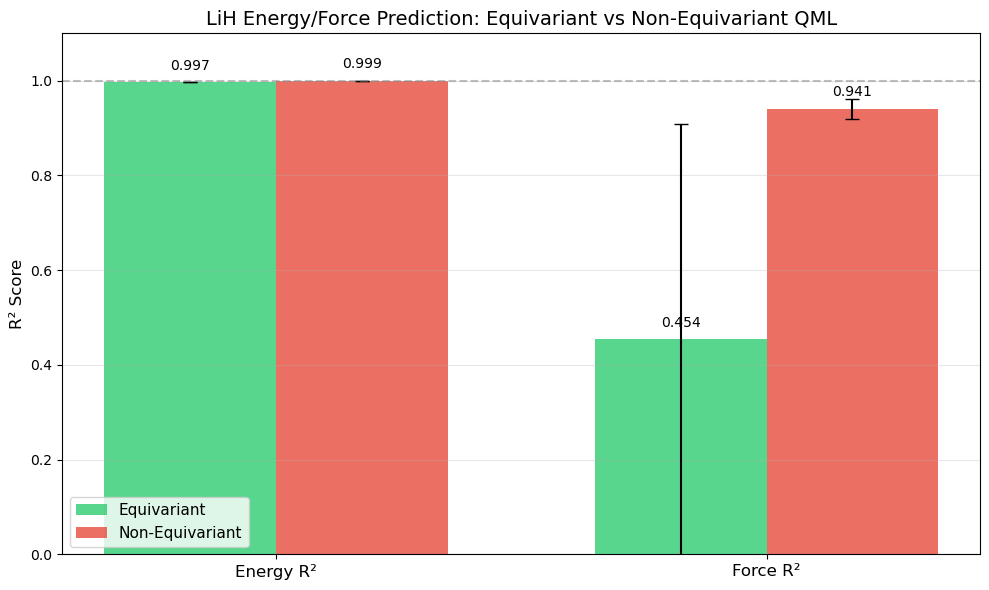

Saved: figures/comparison_mae.png


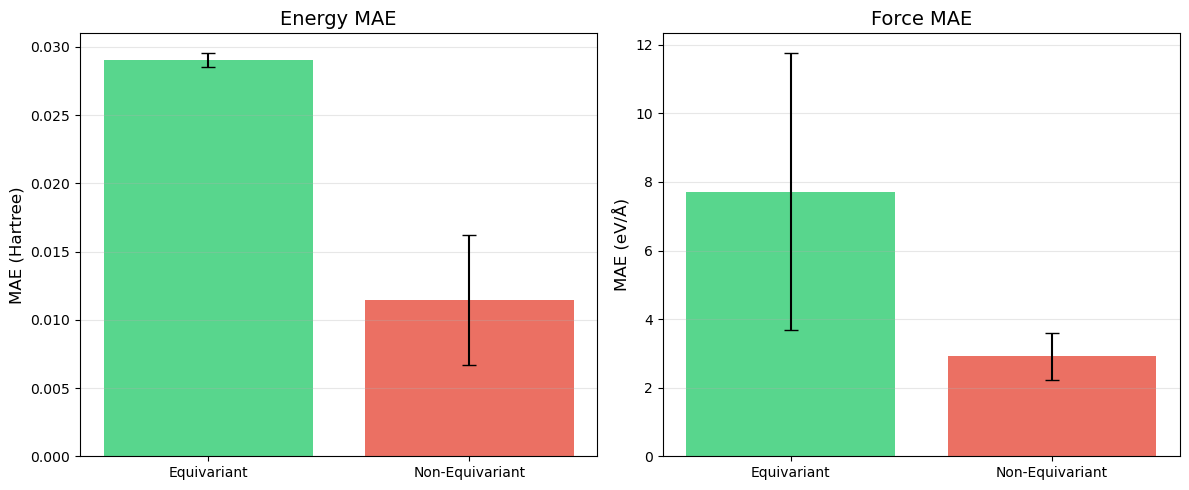

Saved: figures/training_curves.png


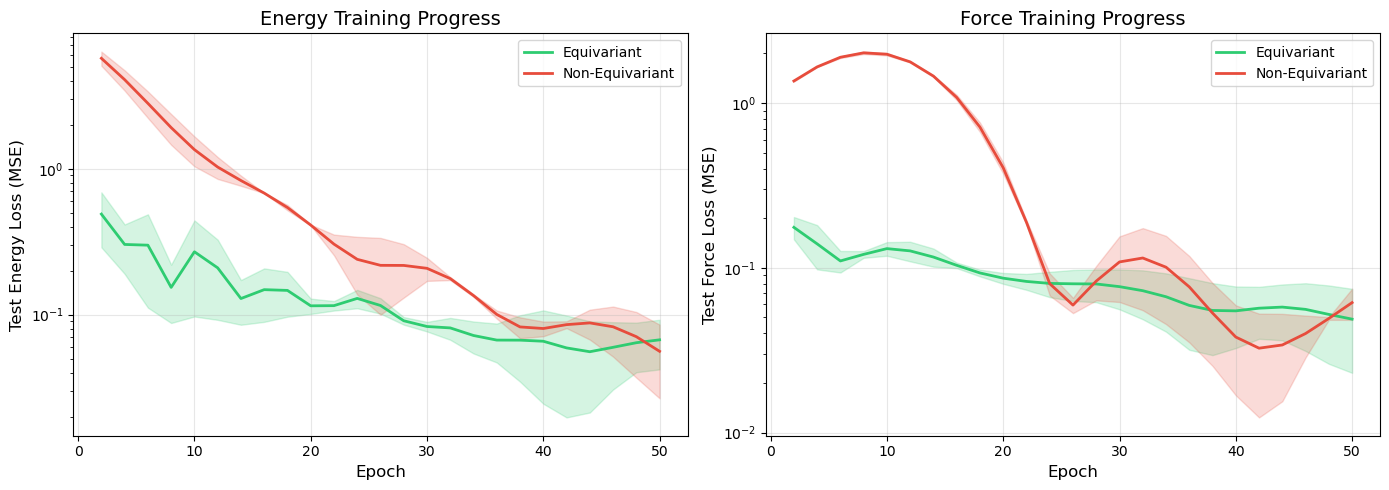

Saved: figures/predictions.png


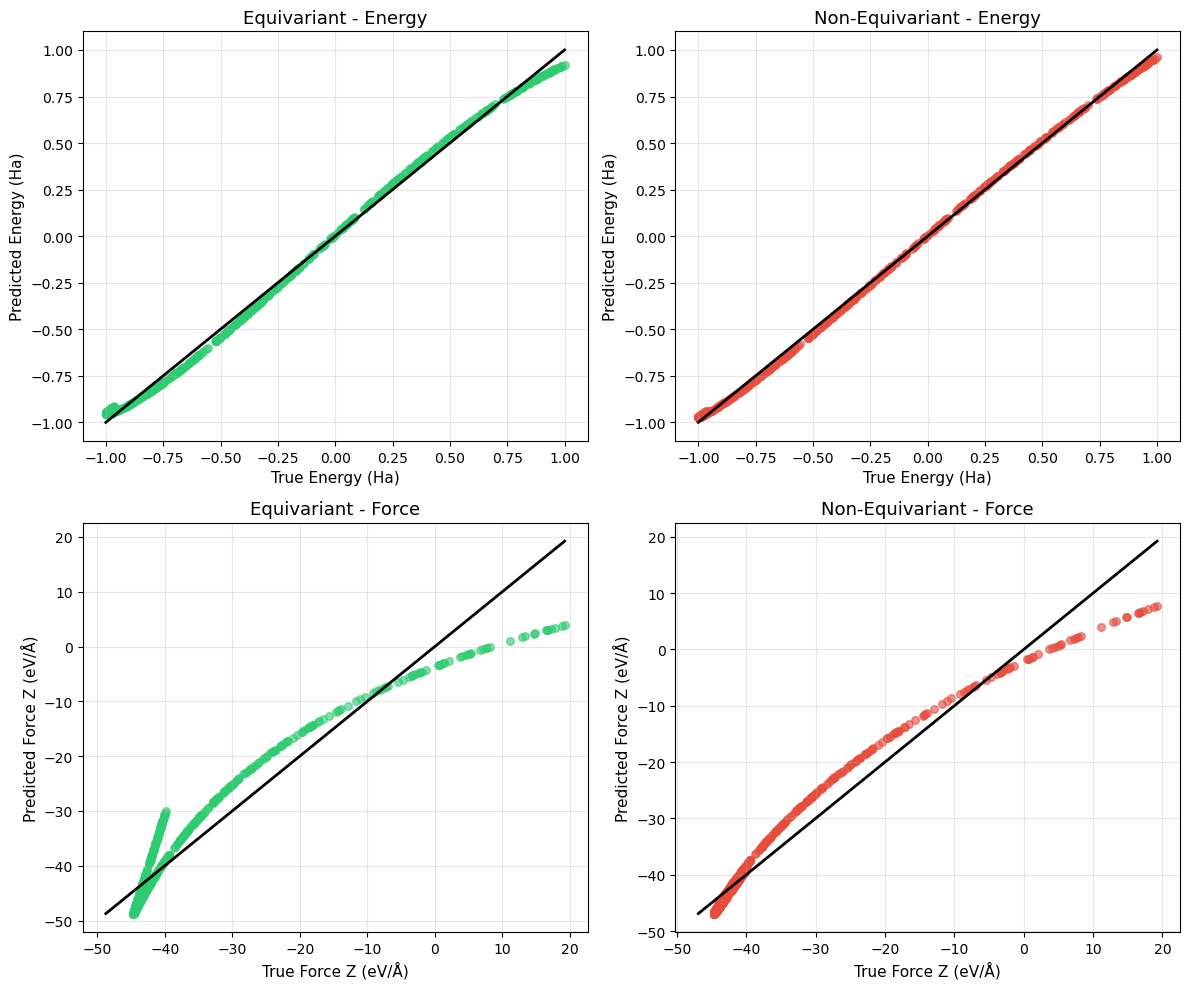

In [4]:
reader = main('results', plot='all', save_dir='figures', show=True)

# Relabelled #

In [5]:
"""
Reader Script for LiH QML Comparison Results

Loads data saved by run_comparison.py and generates plots/analysis.

Usage:
    python read_results.py <results_dir>
    python read_results.py results --plot all --save figures/
    
    or as module:
    from read_results import ResultsReader
    reader = ResultsReader("results")
    reader.plot_comparison()
"""

import numpy as np
import json
import os
import matplotlib.pyplot as plt
import argparse


class ResultsReader:
    """Reader for LiH QML comparison results."""
    
    def __init__(self, results_dir):
        """Load results from directory."""
        self.results_dir = results_dir
        self.results = None
        self.metrics = None
        
        self._load_data()
    
    def _load_data(self):
        """Load all data files."""
        print(f"Loading results from: {self.results_dir}")
        
        # Load JSON results
        json_path = os.path.join(self.results_dir, "results.json")
        if os.path.exists(json_path):
            with open(json_path, 'r') as f:
                self.results = json.load(f)
            print(f"  ✓ Loaded results.json")
        
        # Load numpy metrics
        npz_path = os.path.join(self.results_dir, "metrics.npz")
        if os.path.exists(npz_path):
            self.metrics = dict(np.load(npz_path))
            print(f"  ✓ Loaded metrics.npz")
    
    def print_summary(self):
        """Print summary statistics."""
        if not self.results:
            print("No results loaded")
            return
        
        config = self.results.get("config", {})
        
        print("\n" + "="*100)
        print("EXPERIMENT SUMMARY")
        print("="*100)
        print(f"Runs: {config.get('n_runs', 'N/A')}")
        print(f"Epochs: {config.get('n_epochs', 'N/A')}")
        print(f"Timestamp: {config.get('timestamp', 'N/A')}")
        
        print("\n" + "-"*100)
        print(f"{'Metric':<20} {'Rotationally Equivariant QML':<40} {'Graph Embedding Equivariant QML':<40}")
        print("-"*100)
        
        metrics_to_show = ["E_r2", "E_mae_Ha", "E_rmse_Ha", "F_r2", "F_mae", "F_rmse"]
        
        for metric in metrics_to_show:
            eq_summary = self.results["equivariant"]["metrics_summary"].get(metric, {})
            neq_summary = self.results["non_equivariant"]["metrics_summary"].get(metric, {})
            
            eq_str = f"{eq_summary.get('mean', 0):.4f} ± {eq_summary.get('std', 0):.4f}"
            neq_str = f"{neq_summary.get('mean', 0):.4f} ± {neq_summary.get('std', 0):.4f}"
            
            print(f"{metric:<20} {eq_str:<40} {neq_str:<40}")
        
        print("="*100)
    
    def plot_comparison_bars(self, save_path='./lih_results/', show=True):
        """Create bar chart comparing methods."""
        if not self.results:
            print("No results loaded")
            return None
        
        metrics = ["E_r2", "F_r2"]
        labels = ["Energy R²", "Force R²"]
        
        eq_means = []
        eq_stds = []
        neq_means = []
        neq_stds = []
        
        for m in metrics:
            eq_means.append(self.results["equivariant"]["metrics_summary"][m]["mean"])
            eq_stds.append(self.results["equivariant"]["metrics_summary"][m]["std"])
            neq_means.append(self.results["non_equivariant"]["metrics_summary"][m]["mean"])
            neq_stds.append(self.results["non_equivariant"]["metrics_summary"][m]["std"])
        
        x = np.arange(len(metrics))
        width = 0.35
        
        fig, ax = plt.subplots(figsize=(12, 6))
        
        bars1 = ax.bar(x - width/2, eq_means, width, yerr=eq_stds, 
                       label='Rotationally Equivariant QML', color='#2ecc71', capsize=5, alpha=0.8)
        bars2 = ax.bar(x + width/2, neq_means, width, yerr=neq_stds,
                       label='Graph Embedding Equivariant QML', color='#e74c3c', capsize=5, alpha=0.8)
        
        ax.set_ylabel('R² Score', fontsize=12)
        ax.set_title('LiH Energy/Force Prediction: Rotationally Equivariant vs Graph Embedding Equivariant QML', fontsize=14)
        ax.set_xticks(x)
        ax.set_xticklabels(labels, fontsize=12)
        ax.legend(fontsize=11)
        ax.set_ylim([0, 1.1])
        ax.axhline(y=1.0, color='gray', linestyle='--', alpha=0.5)
        ax.grid(True, alpha=0.3, axis='y')
        
        # Add value labels
        for bar, val in zip(bars1, eq_means):
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                   f'{val:.3f}', ha='center', va='bottom', fontsize=10)
        for bar, val in zip(bars2, neq_means):
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                   f'{val:.3f}', ha='center', va='bottom', fontsize=10)
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"Saved: {save_path}")
        
        if show:
            plt.show()
        else:
            plt.close()
        
        return fig
    
    def plot_mae_comparison(self, save_path='./lih_results/', show=True):
        """Create bar chart for MAE comparison."""
        if not self.results:
            return None
        
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))
        
        # Energy MAE
        ax = axes[0]
        eq_mae = self.results["equivariant"]["metrics_summary"]["E_mae_Ha"]
        neq_mae = self.results["non_equivariant"]["metrics_summary"]["E_mae_Ha"]
        
        x = [0, 1]
        bars = ax.bar(x, [eq_mae["mean"], neq_mae["mean"]], 
                     yerr=[eq_mae["std"], neq_mae["std"]],
                     color=['#2ecc71', '#e74c3c'], capsize=5, alpha=0.8)
        ax.set_xticks(x)
        ax.set_xticklabels(['Rotationally\nEquivariant QML', 'Graph Embedding\nEquivariant QML'])
        ax.set_ylabel('MAE (Hartree)', fontsize=12)
        ax.set_title('Energy MAE', fontsize=14)
        ax.grid(True, alpha=0.3, axis='y')
        
        # Force MAE
        ax = axes[1]
        eq_mae = self.results["equivariant"]["metrics_summary"]["F_mae"]
        neq_mae = self.results["non_equivariant"]["metrics_summary"]["F_mae"]
        
        bars = ax.bar(x, [eq_mae["mean"], neq_mae["mean"]], 
                     yerr=[eq_mae["std"], neq_mae["std"]],
                     color=['#2ecc71', '#e74c3c'], capsize=5, alpha=0.8)
        ax.set_xticks(x)
        ax.set_xticklabels(['Rotationally\nEquivariant QML', 'Graph Embedding\nEquivariant QML'])
        ax.set_ylabel('MAE (eV/Å)', fontsize=12)
        ax.set_title('Force MAE', fontsize=14)
        ax.grid(True, alpha=0.3, axis='y')
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"Saved: {save_path}")
        
        if show:
            plt.show()
        else:
            plt.close()
        
        return fig
    
    def plot_training_curves(self, save_path='./lih_results/', show=True):
        """Plot training loss curves."""
        if not self.results:
            return None
        
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))
        
        colors = {'equivariant': '#2ecc71', 'non_equivariant': '#e74c3c'}
        labels = {'equivariant': 'Rotationally Equivariant QML', 'non_equivariant': 'Graph Embedding Equivariant QML'}
        
        for model_type in ['equivariant', 'non_equivariant']:
            runs = self.results[model_type]["runs"]
            
            # Collect all training curves
            all_E_loss = []
            all_F_loss = []
            epochs = None
            
            for run in runs:
                history = run.get("history", {})
                if history.get("epoch"):
                    epochs = history["epoch"]
                    all_E_loss.append(history.get("test_E_loss", []))
                    all_F_loss.append(history.get("test_F_loss", []))
            
            if not epochs or not all_E_loss:
                continue
            
            # Average across runs
            min_len = min(len(h) for h in all_E_loss)
            all_E_loss = [h[:min_len] for h in all_E_loss]
            all_F_loss = [h[:min_len] for h in all_F_loss]
            epochs = epochs[:min_len]
            
            mean_E = np.mean(all_E_loss, axis=0)
            std_E = np.std(all_E_loss, axis=0)
            mean_F = np.mean(all_F_loss, axis=0)
            std_F = np.std(all_F_loss, axis=0)
            
            # Energy loss
            axes[0].plot(epochs, mean_E, color=colors[model_type], 
                        label=labels[model_type], linewidth=2)
            axes[0].fill_between(epochs, mean_E - std_E, mean_E + std_E,
                                color=colors[model_type], alpha=0.2)
            
            # Force loss
            axes[1].plot(epochs, mean_F, color=colors[model_type],
                        label=labels[model_type], linewidth=2)
            axes[1].fill_between(epochs, mean_F - std_F, mean_F + std_F,
                                color=colors[model_type], alpha=0.2)
        
        axes[0].set_xlabel('Epoch', fontsize=12)
        axes[0].set_ylabel('Test Energy Loss (MSE)', fontsize=12)
        axes[0].set_title('Energy Training Progress', fontsize=14)
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)
        axes[0].set_yscale('log')
        
        axes[1].set_xlabel('Epoch', fontsize=12)
        axes[1].set_ylabel('Test Force Loss (MSE)', fontsize=12)
        axes[1].set_title('Force Training Progress', fontsize=14)
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)
        axes[1].set_yscale('log')
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"Saved: {save_path}")
        
        if show:
            plt.show()
        else:
            plt.close()
        
        return fig
    
    def plot_predictions(self, run_idx=0, save_path='./lih_results/', show=True):
        """Plot predicted vs true values."""
        if not self.results:
            return None
        
        fig, axes = plt.subplots(2, 2, figsize=(12, 10))
        
        for col, model_type in enumerate(['equivariant', 'non_equivariant']):
            run = self.results[model_type]["runs"][run_idx]
            preds = run.get("predictions", {})
            
            if not preds:
                continue
            
            E_pred = np.array(preds["E_pred"])
            E_true = np.array(preds["E_true"])
            F_pred = np.array(preds["F_pred"])
            F_true = np.array(preds["F_true"])
            test_idx = preds["indices_test"]
            
            E_pred_test = E_pred[test_idx]
            E_true_test = E_true[test_idx]
            F_pred_test = F_pred[test_idx]
            F_true_test = F_true[test_idx]
            
            color = '#2ecc71' if model_type == 'equivariant' else '#e74c3c'
            title = 'Rotationally Equivariant QML' if model_type == 'equivariant' else 'Graph Embedding Equivariant QML'
            
            # Energy
            ax = axes[0, col]
            ax.scatter(E_true_test, E_pred_test, alpha=0.6, color=color, s=30)
            lims = [min(E_true_test.min(), E_pred_test.min()), 
                   max(E_true_test.max(), E_pred_test.max())]
            ax.plot(lims, lims, 'k-', linewidth=2)
            ax.set_xlabel('True Energy (Ha)', fontsize=11)
            ax.set_ylabel('Predicted Energy (Ha)', fontsize=11)
            ax.set_title(f'{title} - Energy', fontsize=12)
            ax.grid(True, alpha=0.3)
            
            # Force
            ax = axes[1, col]
            ax.scatter(F_true_test, F_pred_test, alpha=0.6, color=color, s=30)
            lims = [min(F_true_test.min(), F_pred_test.min()),
                   max(F_true_test.max(), F_pred_test.max())]
            ax.plot(lims, lims, 'k-', linewidth=2)
            ax.set_xlabel('True Force Z (eV/Å)', fontsize=11)
            ax.set_ylabel('Predicted Force Z (eV/Å)', fontsize=11)
            ax.set_title(f'{title} - Force', fontsize=12)
            ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"Saved: {save_path}")
        
        if show:
            plt.show()
        else:
            plt.close()
        
        return fig
    
    def plot_all(self, output_dir=None, show=True):
        """Generate all plots."""
        if output_dir:
            os.makedirs(output_dir, exist_ok=True)
        
        plots = {
            "comparison_r2.png": self.plot_comparison_bars,
            "comparison_mae.png": self.plot_mae_comparison,
            "training_curves.png": self.plot_training_curves,
            "predictions.png": self.plot_predictions,
        }
        
        for filename, plot_func in plots.items():
            save_path = os.path.join(output_dir, filename) if output_dir else None
            plot_func(save_path=save_path, show=show)
    
    def export_csv(self, output_path):
        """Export summary to CSV."""
        if not self.results:
            return
        
        lines = ["Model,Metric,Mean,Std,Min,Max"]
        
        for model_type in ["equivariant", "non_equivariant"]:
            summary = self.results[model_type]["metrics_summary"]
            for metric, stats in summary.items():
                line = f"{model_type},{metric},{stats['mean']:.6f},{stats['std']:.6f},"
                line += f"{stats['min']:.6f},{stats['max']:.6f}"
                lines.append(line)
        
        with open(output_path, 'w') as f:
            f.write('\n'.join(lines))
        
        print(f"CSV exported: {output_path}")
    
    def get_metric(self, model_type, metric_name):
        """Get specific metric values."""
        if not self.results:
            return None
        return self.results[model_type]["metrics_summary"].get(metric_name, {})


def main(results_dir, plot='all', save_dir='./lih_results/', csv=None, show=True):
    """
    Main function - can be called directly from Jupyter or command line.
    
    Args:
        results_dir: Directory containing results
        plot: Type of plot ('comparison', 'mae', 'training', 'predictions', 'all')
        save_dir: Directory to save plots (optional)
        csv: Path to export CSV (optional)
        show: Whether to display plots
    
    Returns:
        ResultsReader object
    """
    reader = ResultsReader(results_dir)
    reader.print_summary()
    
    if csv:
        reader.export_csv(csv)
    
    if save_dir:
        os.makedirs(save_dir, exist_ok=True)
    
    if plot == 'all':
        reader.plot_all(output_dir=save_dir, show=show)
    elif plot == 'comparison':
        path = os.path.join(save_dir, "comparison_r2.png") if save_dir else None
        reader.plot_comparison_bars(save_path=path, show=show)
    elif plot == 'mae':
        path = os.path.join(save_dir, "comparison_mae.png") if save_dir else None
        reader.plot_mae_comparison(save_path=path, show=show)
    elif plot == 'training':
        path = os.path.join(save_dir, "training_curves.png") if save_dir else None
        reader.plot_training_curves(save_path=path, show=show)
    elif plot == 'predictions':
        path = os.path.join(save_dir, "predictions.png") if save_dir else None
        reader.plot_predictions(save_path=path, show=show)
    
    return reader


if __name__ == "__main__":
    import sys
    
    # Check if running in Jupyter
    if 'ipykernel' in sys.modules:
        print("Running in Jupyter notebook. Call main() directly with parameters:")
        print("  reader = main('lih_results', plot='all', save_dir='figures', show=True)")
        print("\nOr use the ResultsReader class directly:")
        print("  reader = ResultsReader('lih_results')")
        print("  reader.print_summary()")
        print("  reader.plot_comparison_bars()")
    else:
        parser = argparse.ArgumentParser(description="Read and analyze LiH QML comparison results")
        parser.add_argument("results_dir", help="Directory containing results")
        parser.add_argument("--plot", choices=['comparison', 'mae', 'training', 'predictions', 'all'],
                           default='all', help="Type of plot")
        parser.add_argument("--save_dir", type=str, help="Directory to save plots")
        parser.add_argument("--csv", type=str, help="Export to CSV")
        parser.add_argument("--no-show", action="store_true", help="Don't display plots")
        
        args = parser.parse_args()
        
        main(
            results_dir=args.results_dir,
            plot=args.plot,
            save_dir=args.save_dir,
            csv=args.csv,
            show=not args.no_show
        )

Running in Jupyter notebook. Call main() directly with parameters:
  reader = main('lih_results', plot='all', save_dir='figures', show=True)

Or use the ResultsReader class directly:
  reader = ResultsReader('lih_results')
  reader.print_summary()
  reader.plot_comparison_bars()


Loading results from: lih_results
  ✓ Loaded results.json
  ✓ Loaded metrics.npz

EXPERIMENT SUMMARY
Runs: 1
Epochs: 200
Timestamp: 2025-11-26T00:54:34.754145

----------------------------------------------------------------------------------------------------
Metric               Rotationally Equivariant QML             Graph Embedding Equivariant QML         
----------------------------------------------------------------------------------------------------
E_r2                 0.9966 ± 0.0000                          0.9979 ± 0.0000                         
E_mae_Ha             0.0334 ± 0.0000                          0.0262 ± 0.0000                         
E_rmse_Ha            0.0381 ± 0.0000                          0.0300 ± 0.0000                         
F_r2                 0.9239 ± 0.0000                          0.9584 ± 0.0000                         
F_mae                3.2999 ± 0.0000                          2.5130 ± 0.0000                         
F_rmse              

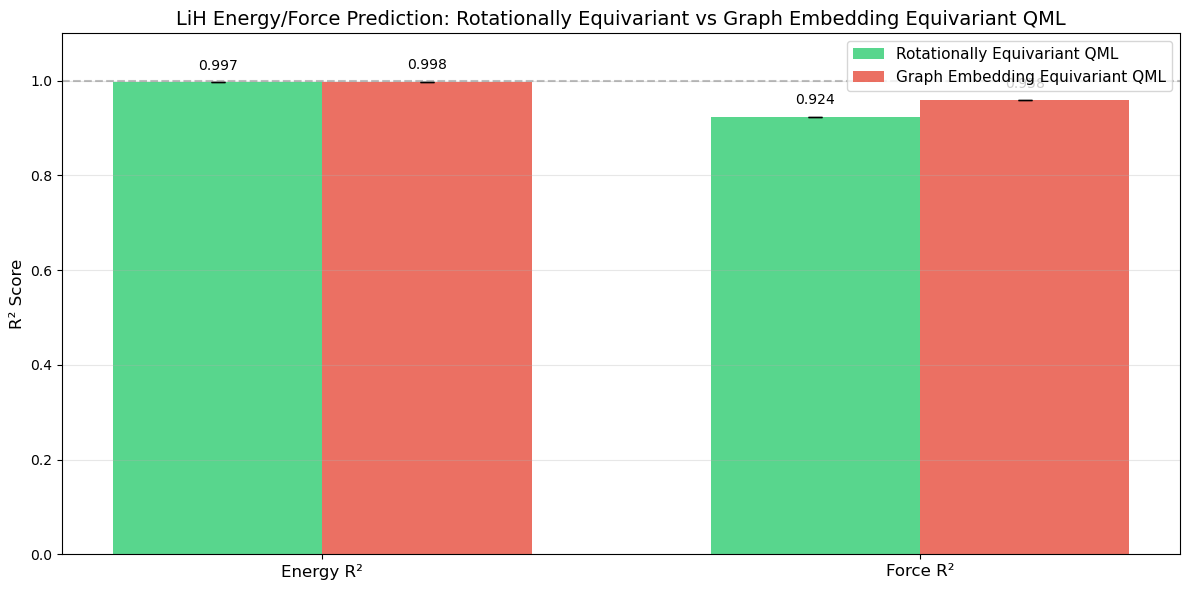

Saved: figures/comparison_mae.png


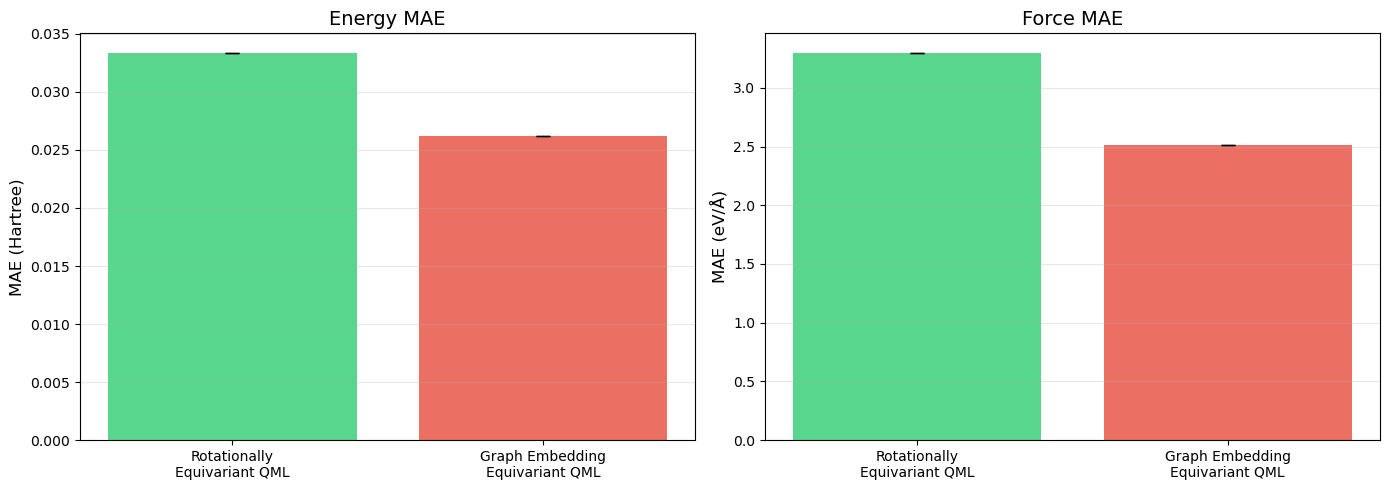

Saved: figures/training_curves.png


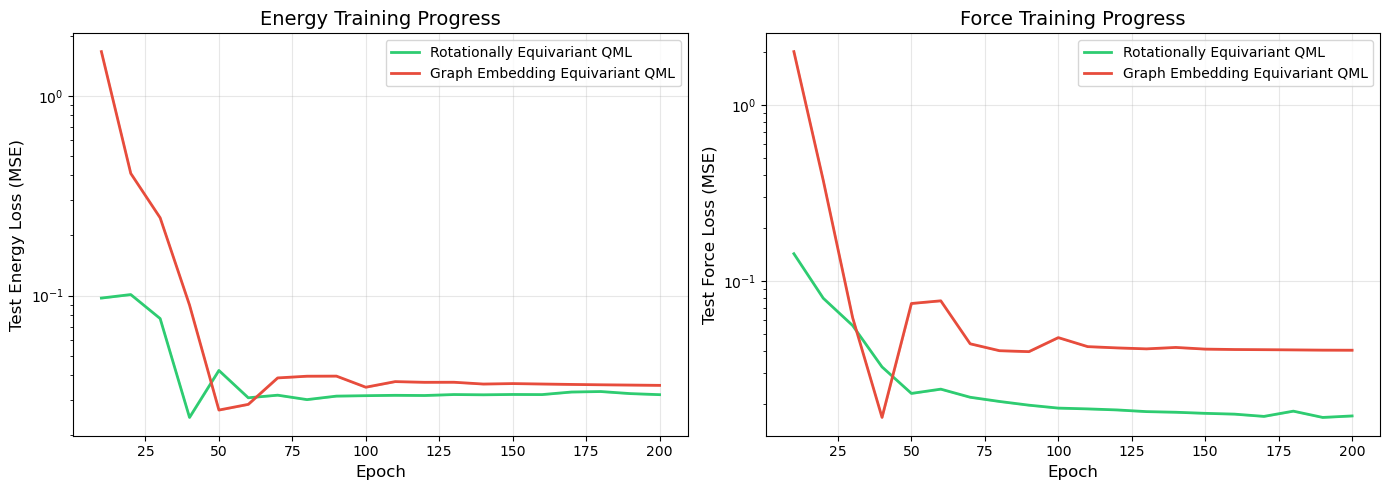

Saved: figures/predictions.png


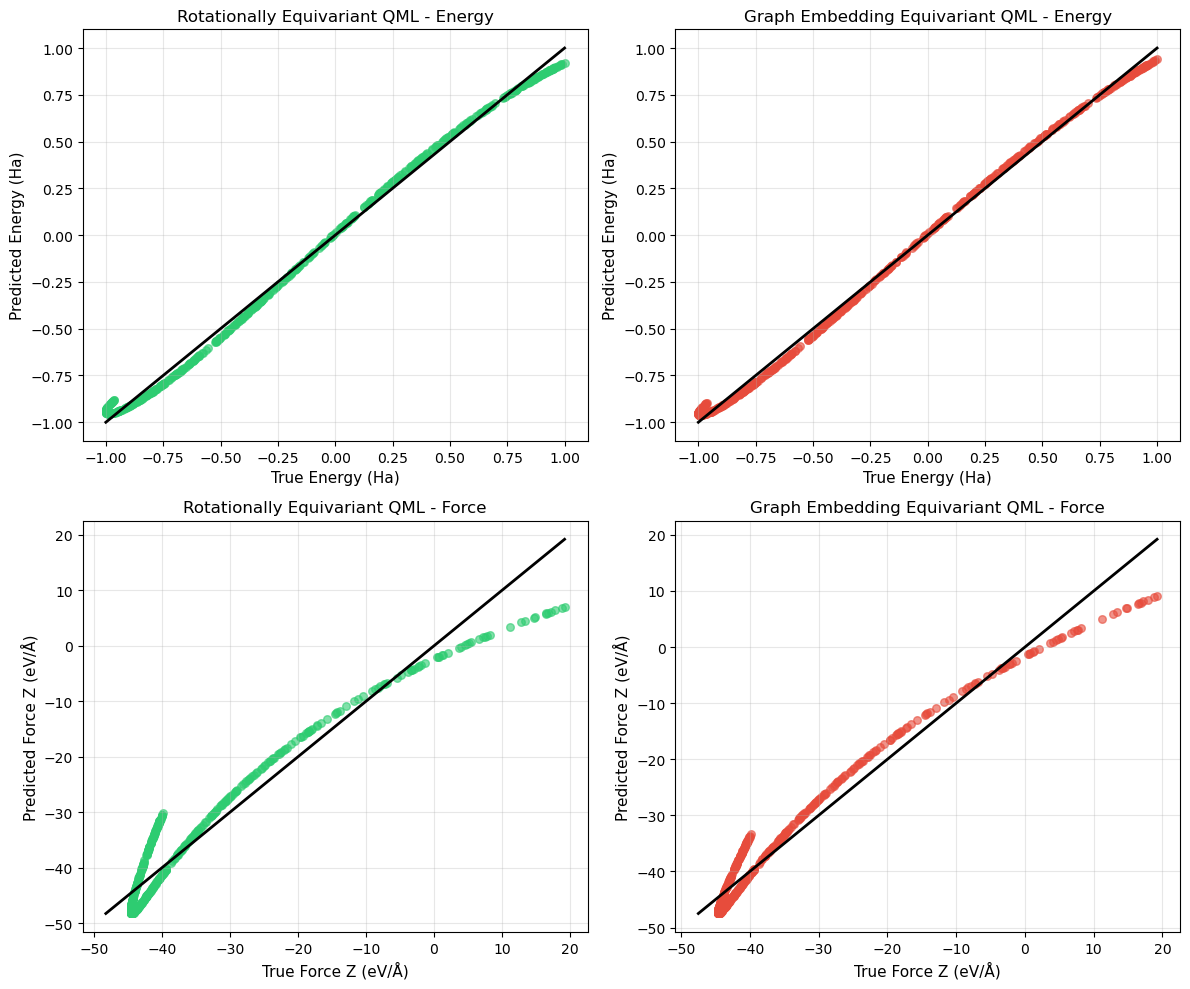

In [6]:
reader = main('lih_results', plot='all', save_dir='figures', show=True)